# Step 1: Creating Tokens

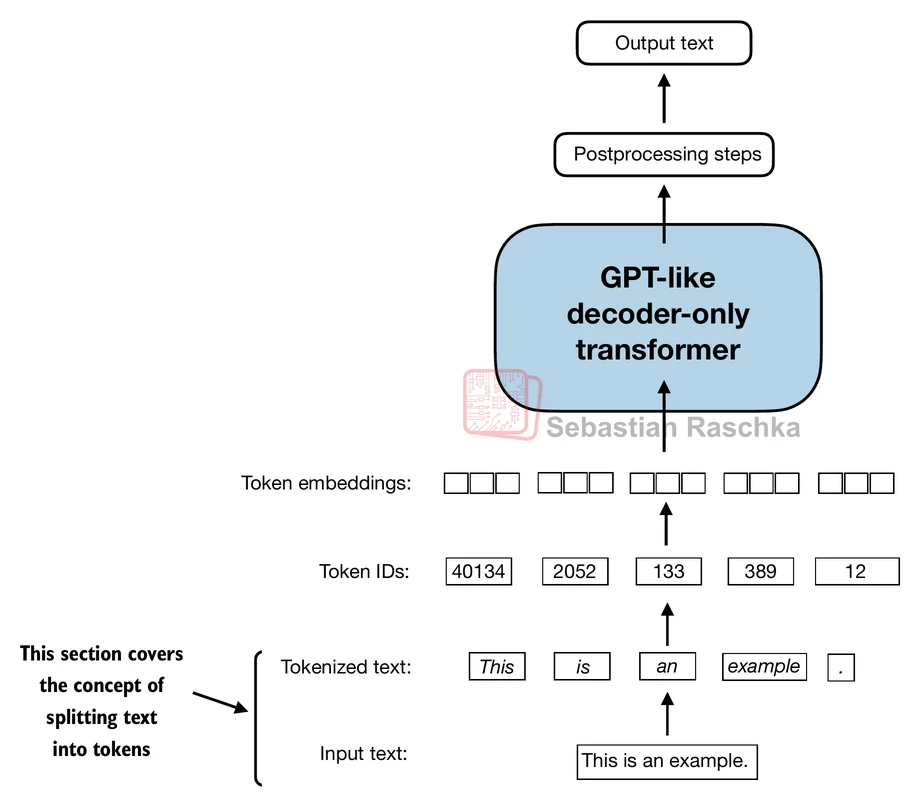

In [54]:
with open("the verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total No of Characters:", len(raw_text))
print(raw_text[:99])

Total No of Characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


Our goal is to tokenize the text into individual words and special characters that can then turn into embedding for LLM training

We will use regular expression to split on whitespaces

In [55]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)  # We split where ever white spaces exist
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


We don't only want to split on whitespaces but also commas and periods, so let's modify the regular expression to do that as well

In [56]:
result = re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


A small remaining issue is that the list still include whitespace characters

In [57]:
cleaned_result = []

for x in result:

    # remove any extra space from the item

    stripeed_item = x.strip()

    if stripeed_item !='':
        cleaned_result.append(x)

result = cleaned_result
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


REMOVING WHITESPACES OR NOT

When developing a simple tokenizer, whether we should encode whitespaces as separate characters or just remove them depends on our application and its requirements. Removing whitespaces reduces the memory and computing requirements. However, keeping whitespaces can be useful if we train models that are sensitive to the exact structure of the text (for example, Python code, which is sensitive to indentation and spacing). Here, we remove whitespaces for simplicity and brevity of the tokenized outputs. Later, we will switch to a tokenization scheme that includes whitespaces.

The tokenization scheme we devised above works well on the simple sample text. Let's modify it a bit further so that it can also handle other types of punctuation, such as question marks, quotation marks, and the double-dashes we have seen earlier in the first 100 characters of Edith Wharton's short story, along with additional special characters:

In [58]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)

cleaned_result = []

for x in result:

    # remove any extra space from the item

    stripeed_item = x.strip()

    if stripeed_item !='':
        cleaned_result.append(x)

result = cleaned_result
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


Now that we got a basic tokenizer working, let's apply it to Verdict text file

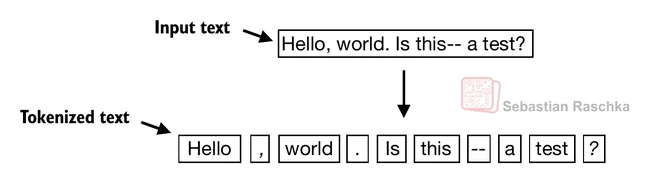

In [59]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)

cleaned_result = []

for x in preprocessed:

    # remove any extra space from the item

    stripeed_item = x.strip()

    if stripeed_item !='':
        cleaned_result.append(x)

preprocessed = cleaned_result
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [60]:
print(len(preprocessed))

4690


# Step 2: Creating Token IDs

Now lets convert the tokens into token IDs 

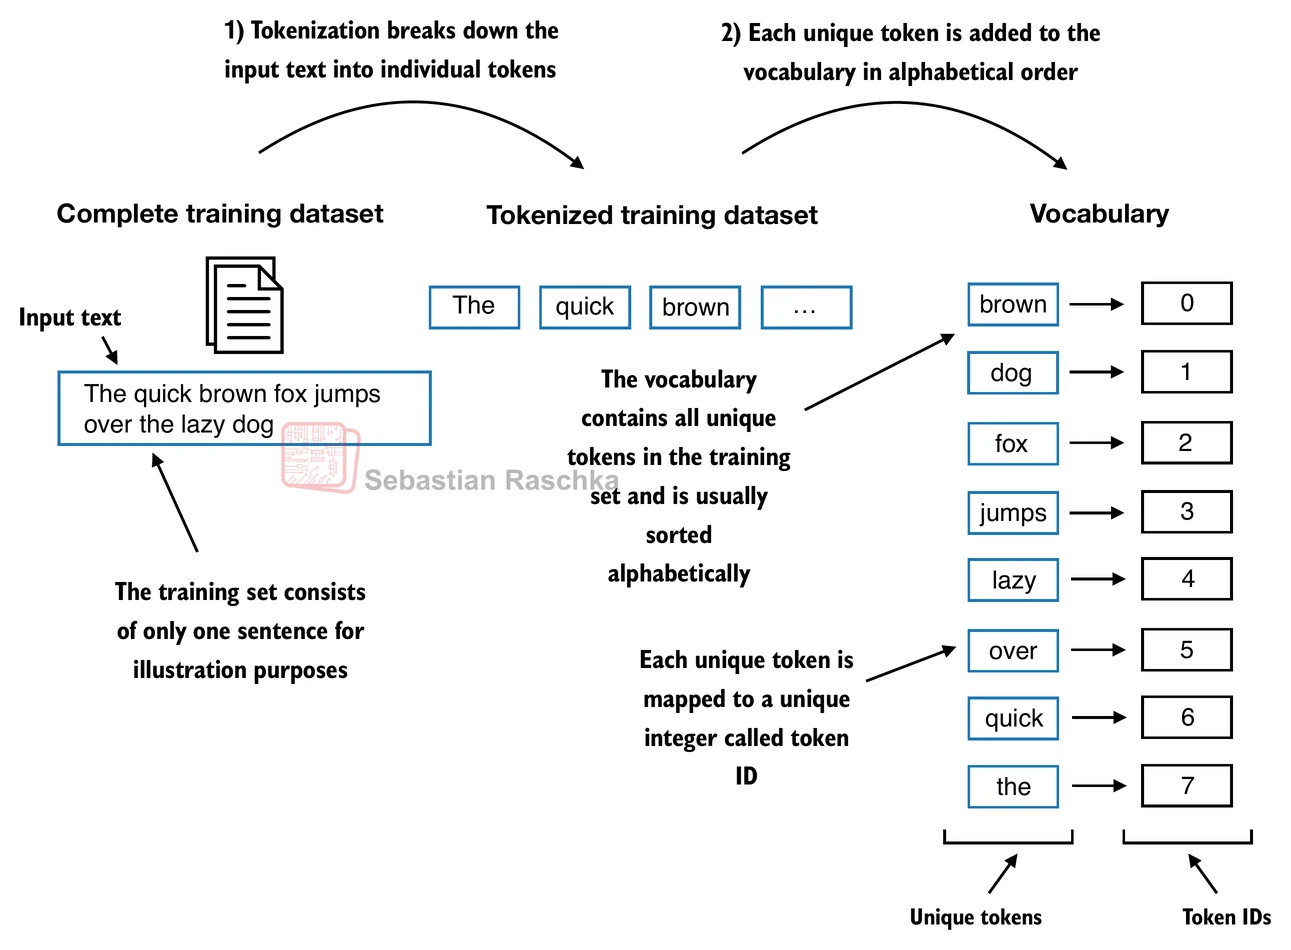

In [61]:
all_word = sorted(set(preprocessed))
vocab_size = len(all_word)

# Vocabulary size will be less since it only consider unique
print(vocab_size)

1130


In [62]:
vocab = {}

for i, word in enumerate(all_word):
    vocab[word] = i


In [63]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i>=50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


Later in this book, when we want to convert the outputs of an LLM from numbers back into text, we also need a way to turn token IDs into text.

For this, we can create an inverse version of the vocabulary that maps token IDs back to corresponding text tokens.

Let's implement a complete tokenizer class in Python.

The class will have an encode method that splits text into tokens and carries out the string-to-integer mapping to produce token IDs via the vocabulary.

In addition, we implement a decode method that carries out the reverse integer-to-string mapping to convert the token IDs back into text.

Step 1: Store the vocabulary as a class attribute for access in the encode and decode methods

Step 2: Create an inverse vocabulary that maps token IDs back to the original text tokens

Step 3: Process input text into token IDs

Step 4: Convert token IDs back into text

Step 5: Replace spaces before the specified punctuation

In [64]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int=vocab
        self.int_to_str= {i:s for s,i in vocab.items()}

    def encode(self,text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])

        # Replace spaces before the specified puntation

        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text


The encode function turns text into token IDs

The decode function turns token IDs back into text


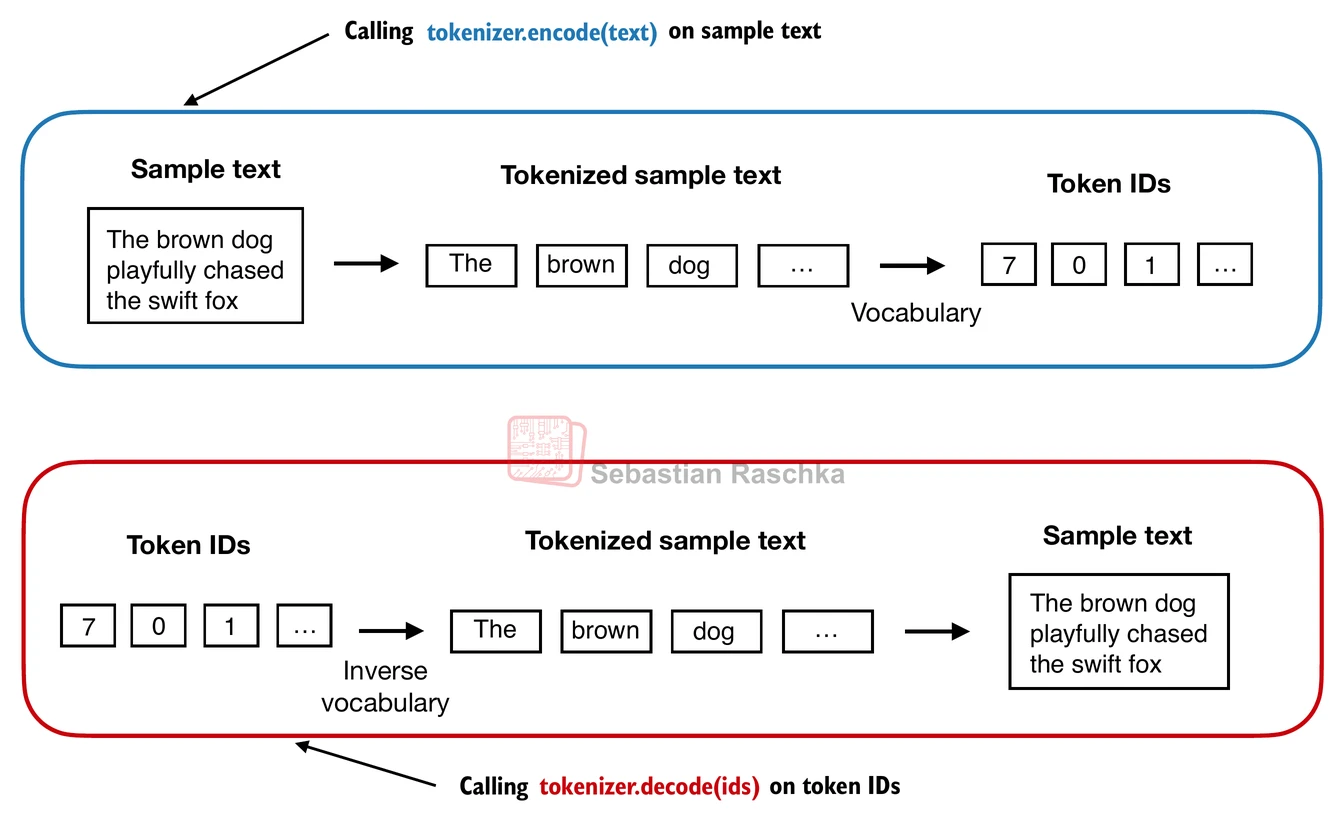

Let's instantiate a new tokenizer object from the SimpleTokenizerV1 class and tokenize a passage from Edith Wharton's short story to try it out in practice:

In [65]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs.Gisburn said with pardonable pride."""

ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


we can decode the integers back into text

In [66]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [67]:
tokenizer.decode(tokenizer.encode(text))

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

Lets now check a new text sample that is not in the trianing set

In [68]:
text = "Hello, do you like tea?"
print(tokenizer.encode(text))

KeyError: 'Hello'

The problem is that the word "Hello" was not used in the The Verdict short story.

Hence, it is not contained in the vocabulary.

This highlights the need to consider large and diverse training sets to extend the vocabulary when working on LLM

# Adding Special Context Tokens

In this section, we will modify this tokenizer to handle unknown words.

In particular, we will modify the vocabulary and tokenizer we implemented in the previous section, SimpleTokenizerV2, to support two new tokens, <|unk|> and <|endoftext|>

We can modify the tokenizer to use an <|unk|> token if it encounters a word that is not part of the vocabulary.

Furthermore, we add a token between unrelated texts.

For example, when training GPT-like LLMs on multiple independent documents or books, it is common to insert a token before each document or book that follows a previous text source

Let's now modify the vocabulary to include these two special tokens, and <|endoftext|>, by adding these to the list of all unique words that we created in the previous section:

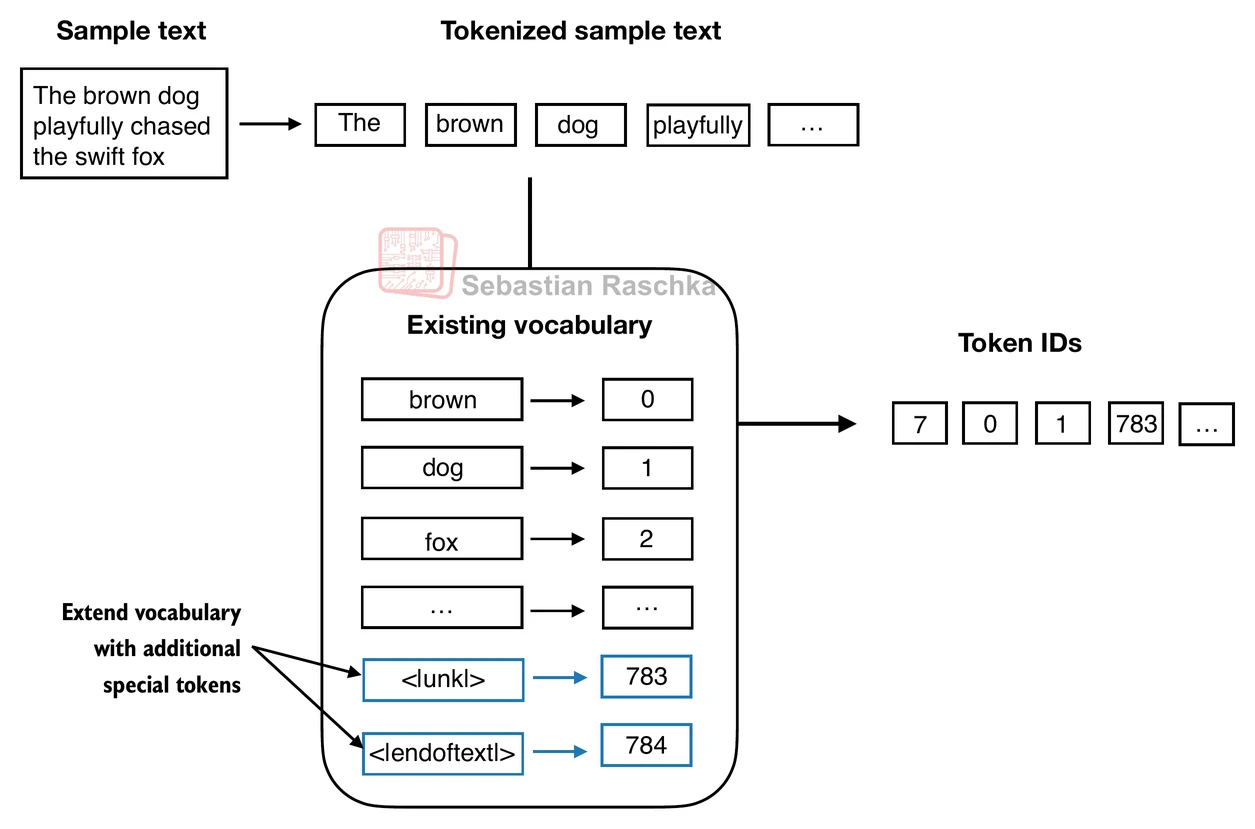

In [69]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token: integer for integer, token in enumerate(all_tokens)}

In [70]:
len(vocab.items())

1132

Based on the output of the print statement above, the new vocabulary size is 1132 (the vocabulary size in the previous section was 1130)

In [71]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)




A simple text tokenizer that handles unknown words




    
Step 1: Replace unknown words by <|unk|> tokens
    
Step 2: Replace spaces before the specified punctuations




In [76]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int=vocab
        self.int_to_str= {i:s for s,i in vocab.items()}

    def encode(self,text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]

        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])

        # Replace spaces before the specified puntation

        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text


In [77]:
tokenizer = SimpleTokenizerV1(vocab)
text1 = "hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [78]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [79]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

Based on comparing the de-tokenized text above with the original input text, we know that the training dataset, Edith Wharton's short story The Verdict, did not contain the words "Hello" and "palace."

So far, we have discussed tokenization as an essential step in processing text as input to LLMs. Depending on the LLM, some researchers also consider additional special tokens such as the following:

[BOS] (beginning of sequence): This token marks the start of a text. It signifies to the LLM where a piece of content begins.

[EOS] (end of sequence): This token is positioned at the end of a text, and is especially useful when concatenating multiple unrelated texts, similar to <|endoftext|>. For instance, when combining two different Wikipedia articles or books, the [EOS] token indicates where one article ends and the next one begins.

[PAD] (padding): When training LLMs with batch sizes larger than one, the batch might contain texts of varying lengths. To ensure all texts have the same length, the shorter texts are extended or "padded" using the [PAD] token, up to the length of the longest text in the batch.

Note that the tokenizer used for GPT models does not need any of these tokens mentioned above but only uses an <|endoftext|> token for simplicity

the tokenizer used for GPT models also doesn't use an <|unk|> token for outof-vocabulary words. Instead, GPT models use a <b>byte pair encoding </b>tokenizer, which breaks down words into subword units